![title]("img/lieb.jpg")

# Lieb lattice in Kwant


Here we study the Lieb lattice by solving tight binding Hamiltonian in Kwant solver 



![title](imag/lieb.jpg)

We'll first plot the dispersion of Lieb lattice with only the nearest neighbor hopping. Then we will study how the dispersion changes with adding additional hopping integrals. 

In [128]:
import kwant
%run matplotlib_setup.ipy
import scipy.linalg as la 
import numpy as np
from kwant.wraparound import wraparound, plot_2d_bands

In [129]:
lieb = kwant.lattice.general([[1,0],[0,1]],  #Lattice vectors
                             [[0,0],[0.5,0],[0,0.5]]) # Coordinates of the sites 

A, B, C = lieb.sublattices
#Here B is essentially equivalent to C
B = C

Let us work with units of "t" = "a" =1.0

In [130]:
sheet1 = kwant.Builder(kwant.TranslationalSymmetry(*lieb.prim_vecs))
sheet1[lieb.shape((lambda pos: True),(0,0))] = 0 
sheet1[lieb.neighbors()] = 1
sheet1 = wraparound(sheet1).finalized()

Below are some helper functions to plot the dispersion

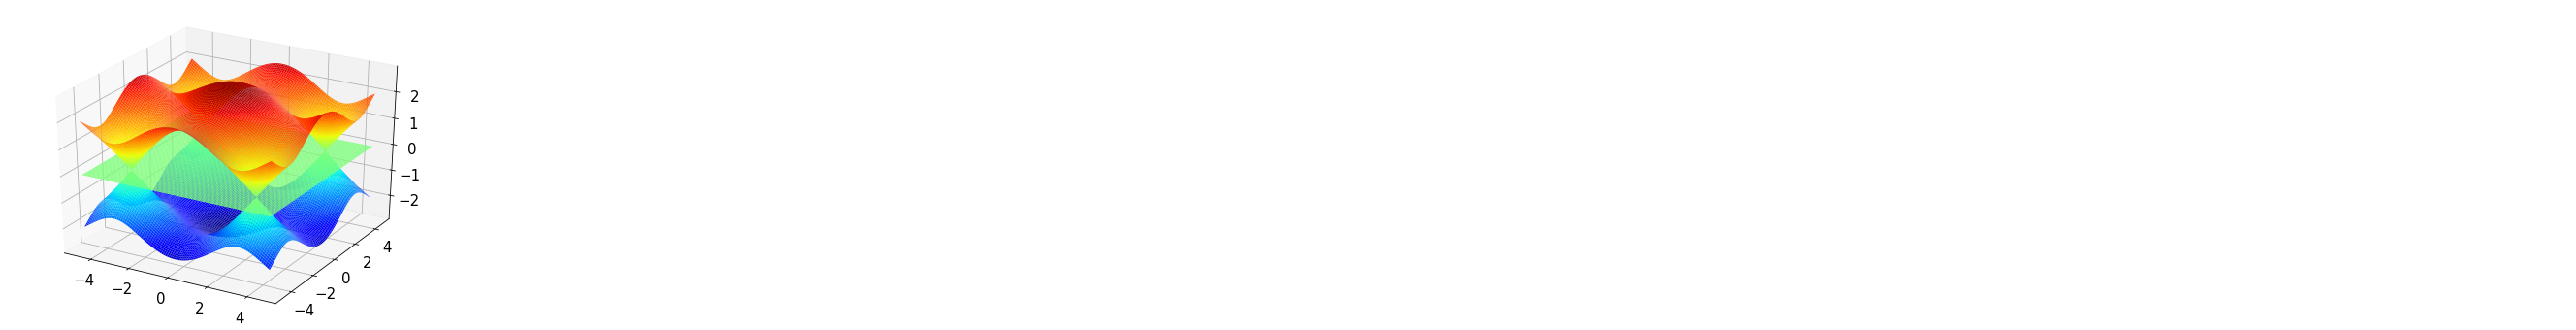

In [131]:
def momentum_to_lattice(k):
    """Transform momentum to the basis of reciprocal lattice vectors.
    
    See https://en.wikipedia.org/wiki/Reciprocal_lattice#Generalization_of_a_dual_lattice
    """
    B = np.array(lieb.prim_vecs).T
    A = B.dot(np.linalg.inv(B.T.dot(B)))
    return np.linalg.solve(A, k)


def dispersion_2D(syst, args=None, lim=1.5*np.pi, num_points=200):
    """A simple plot of 2D band structure."""
    if args is None:
        args = []
    momenta = np.linspace(-lim, lim, num_points)
    energies = []
    for kx in momenta:
        for ky in momenta:
            lattice_k = momentum_to_lattice([kx, ky])
            h = syst.hamiltonian_submatrix(args=(list(args) + list(lattice_k)))
            energies.append(np.linalg.eigvalsh(h))
    
    energies = np.array(energies).reshape(num_points, num_points, -1)
    emin, emax = np.min(energies), np.max(energies)
    kx, ky = np.meshgrid(momenta, momenta)
    fig = pyplot.figure()
    axes = fig.add_subplot(1, 1, 1, projection='3d')
    for band in range(energies.shape[-1]):
        axes.plot_surface(kx, ky, energies[:, :, band], cstride=2, rstride=2,
                          cmap=matplotlib.cm.jet, vmin=emin, vmax=emax,
                          linewidth=1.0)
        
dispersion_2D(sheet1)

***Doubt: Why does the dispersion not depend on the sign of the hopping parameter?***


Dispersion matches with literature (M.R. Slot *et.al*, Nat. Phys. 2017; "https://www.nature.com/articles/nphys4105")
(b) shows the dispersion around the M point in BZ
![title](imag/nphys4105-f1.jpg)

***Doubt: Flat band indicates protected states? But the sheet is continous, so they cannot be edge states! There is only one flat band unlike edge states where flat bands occur in pairs***

Next we add next nearest neighbor hopping into the hamiltonian and see how the dispersion changes

In [132]:
#Some helper functions to make the schematic look neat
def family_color(site): 
    if site.family == A: 
        return 0 
    else: 
        return 1
    
def hopping_lw(site1,site2): 
    return 0.1 if A in [site1.family,site2.family] else 0.05

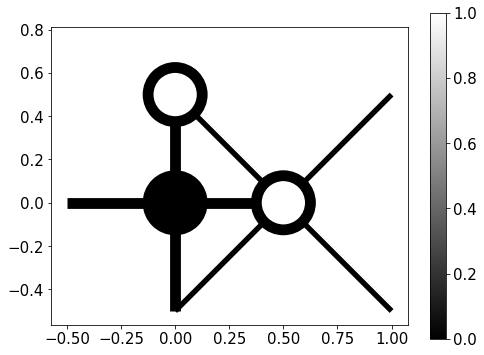

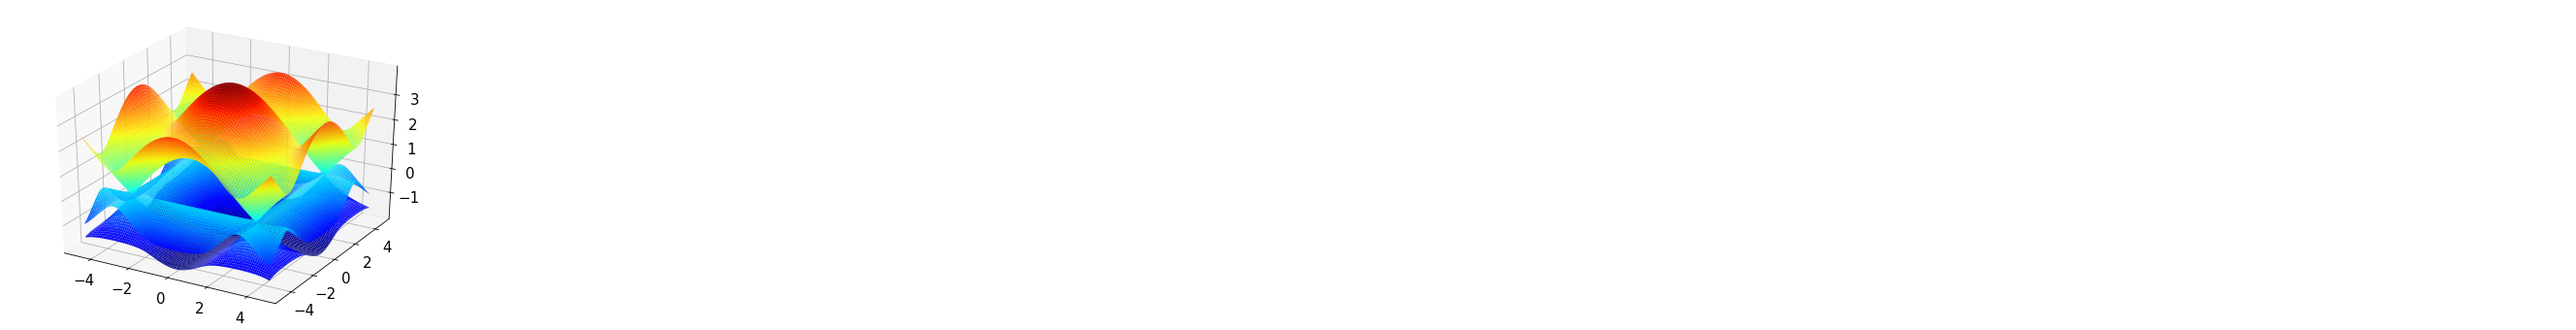

In [133]:
sheet2 = kwant.Builder(kwant.TranslationalSymmetry(*lieb.prim_vecs))
sheet2[lieb.shape((lambda pos: True),(0,0))] = 0 
sheet2[lieb.neighbors()] = 1
sheet2[lieb.neighbors(2)] = 0.5
kwant.plot(sheet2,site_color=family_color,site_lw=0.1,hop_lw=hopping_lw);
sheet2 = wraparound(sheet2).finalized()
dispersion_2D(sheet2)

***Here sign of the hopping matters (??)***

Here the node color's indicate the site family and the linewidth the hopping probability

Including 3rd nearest neighbor hopping

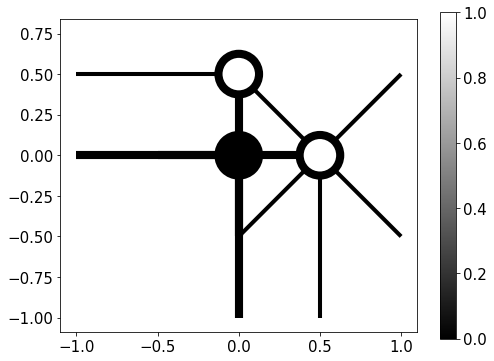

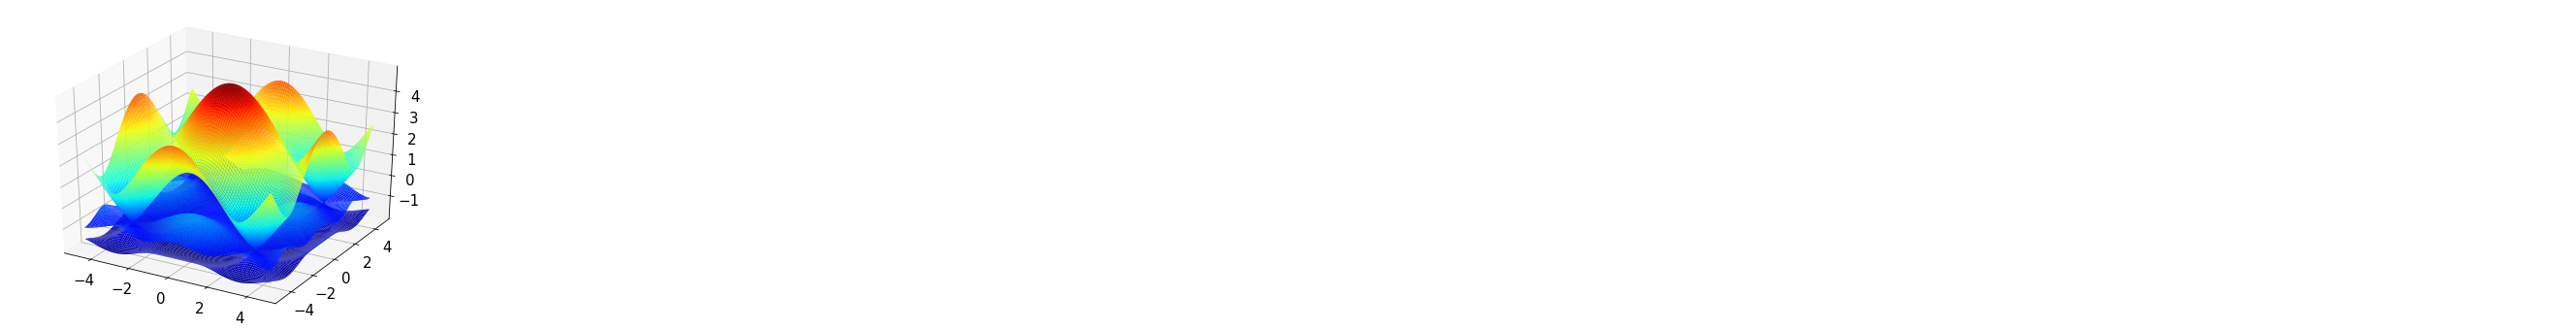

In [134]:
sheet3 = kwant.Builder(kwant.TranslationalSymmetry(*lieb.prim_vecs))
sheet3[lieb.shape((lambda pos: True),(0,0))] = 0 
sheet3[lieb.neighbors()] = 1
sheet3[lieb.neighbors(2)] = 0.5
sheet3[lieb.neighbors(3)] = 0.25
kwant.plot(sheet3,site_color=family_color,site_lw=0.1,hop_lw=hopping_lw);
sheet3 = wraparound(sheet3).finalized()
dispersion_2D(sheet3)

Now the bad is opened and the flat band is distorted

## Nanoribbons

Now we'll remove the periodicity in one of the dimension

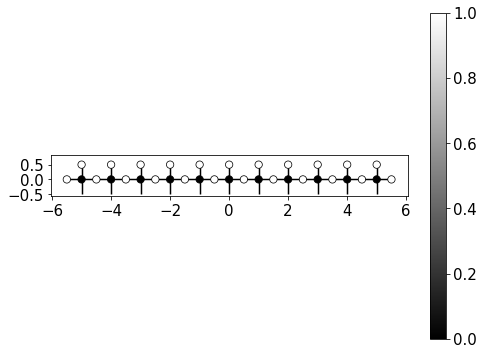

In [135]:
W = 11 #Thickness

ribbon = kwant.Builder(kwant.TranslationalSymmetry(lieb.prim_vecs[1]))
ribbon[lieb.shape(lambda pos: abs(pos[0]) <= W/2, (0,0))] = 0
ribbon[lieb.neighbors()] = 1 
kwant.plot(ribbon,site_color=family_color,hop_lw=hopping_lw,site_lw=0.05);
ribbon = ribbon.finalized()

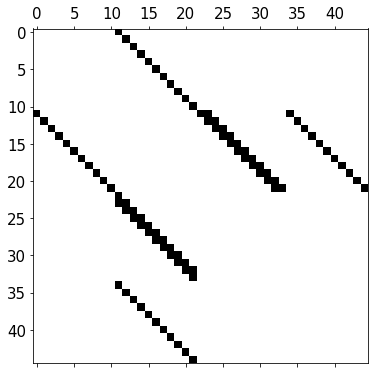

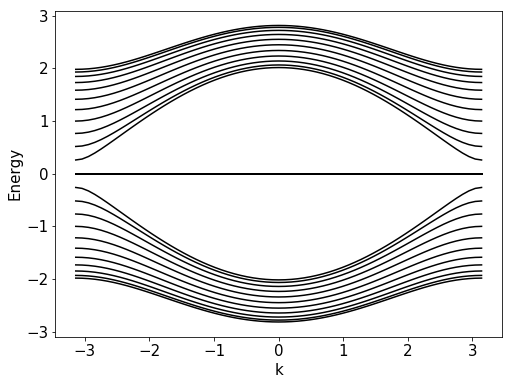

In [136]:
# Eigen values of Hamiltonian
ham = ribbon.hamiltonian_submatrix()
plt.matshow(ham==0, cmap="gray", interpolation=None)
eval, evec = la.eigh(ham)
kwant.plotter.bands(ribbon);

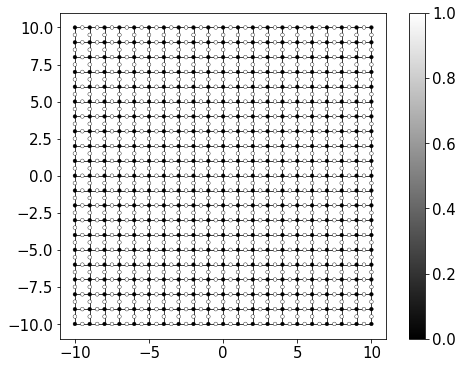

In [137]:
W = 20 #Thickness
L = 20 # Length

#ribbon = kwant.Builder(kwant.TranslationalSymmetry(lieb.prim_vecs[1]))
ribbon1 = kwant.Builder()
ribbon1[lieb.shape(lambda pos: abs(pos[0]) <= W/2 and abs(pos[1])<=L/2, (0,0))] = 0
ribbon1[lieb.neighbors()] = 1 
kwant.plot(ribbon1,site_color=family_color,hop_lw=hopping_lw,site_lw=0.05);
ribbon1 = ribbon1.finalized()

Now we have made the system non-periodic. Let's see what the wave functions look like

In [149]:
# Eigen values of Hamiltonian
ham = ribbon1.hamiltonian_submatrix()
eval, evec = la.eigh(ham)

from ipywidgets import interact

def plot_wf(i=0):
    print("Plotting wave function with index", i)
    print("energy:", eval[i],"x t") 
    kwant.plotter.map(ribbon1, abs(evec[:, i])**2)
    
interact(plot_wf, i=(0, 100));

interactive(children=(IntSlider(value=0, description='i'), Output()), _dom_classes=('widget-interact',))

## Scattering within Lieb nanoribbon

Now let's see how the transmission through the nanoribbon change with electron energy. We create a scattering region of Lieb lattice with flat potential (=0) and attach leads at the ends of it 

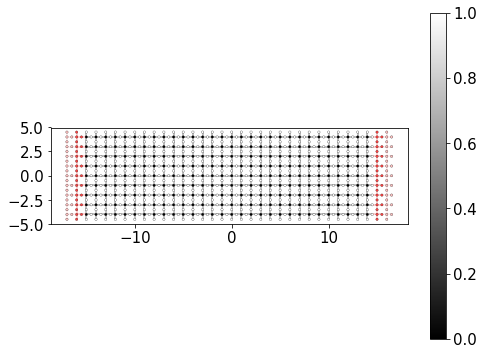

In [150]:
def make_lead_x(W,t):
    """ Returns a lead with width W and nearest neighbor hopping parameter t"""
    lead = kwant.Builder(kwant.TranslationalSymmetry(lieb.prim_vecs[0]))
    lead[lieb.shape(lambda pos: abs(pos[1]) < W/2,(0,0))] = 0 
    lead[lieb.neighbors()] = t
    return lead

def make_wire(W=10, L=30, t=1):
    """ Returns a nano-wire and with leads attached at the ends along x-direction"""
    # Construct the scattering region.
    wr = kwant.Builder()
    wr[lieb.shape(lambda pos: abs(pos[0]) < L/2 and abs(pos[1])<W/2,(0,0))] = 0
    wr[lieb.neighbors()] = t

    # Build and attach lead from both sides.
    lead = make_lead_x(W, t)
    wr.attach_lead(lead)
    wr.attach_lead(lead.reversed())

    return wr

wire = make_wire() 
kwant.plot(wire,site_color=family_color,site_lw=0.05,hop_lw=hopping_lw);
wire = wire.finalized()

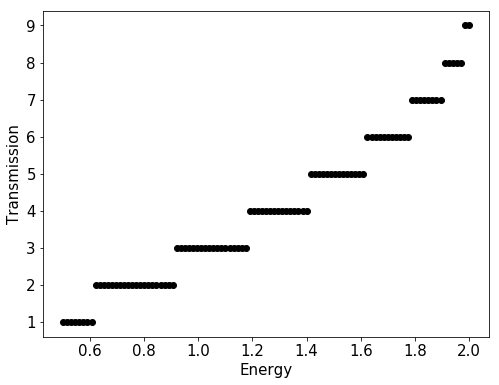

In [151]:
def plot_transmission(syst, energies): 
    #Compute conductance
    trans = [] 
    refl = [] 
    for energy in energies: 
        smatrix = kwant.smatrix(syst,energy)
        trans.append(smatrix.transmission(1,0))
        refl.append(smatrix.transmission)
        
    pyplot.plot(energies,trans,'o')
    pyplot.xlabel("Energy")
    pyplot.ylabel("Transmission")
    
plot_transmission(wire,np.linspace(0.5,2,101))

***Trying to plot Transmission at E=0 raises error saying due to the band being flat. What happens to transmission theoretically when there is a flat band??***

Let's now introduce defects within the scattering region. 

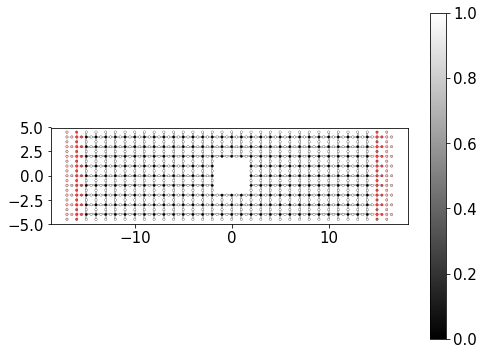

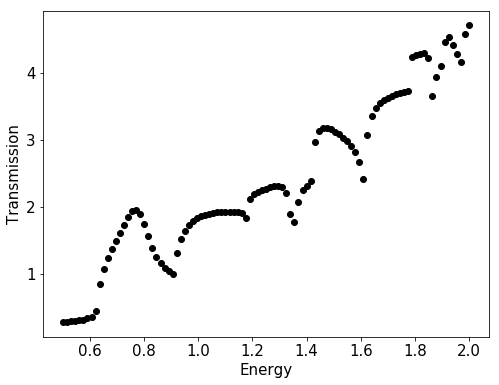

In [152]:
wire1 = make_wire()
del wire1[lieb.shape(lambda pos: pos[0]**2 + pos[1]**2 < 4, (0,0))] # Hole at the center
kwant.plot(wire1,site_color=family_color,site_lw=0.05,hop_lw=hopping_lw);
wire1 = wire1.finalized()
plot_transmission(wire1,np.linspace(0.5,2,101))

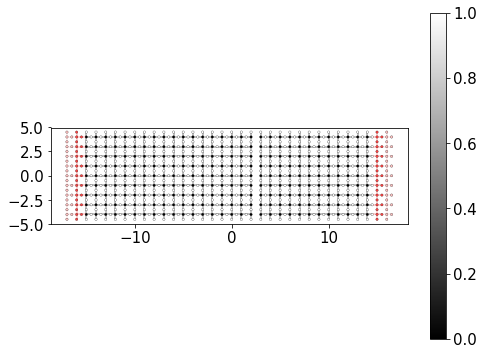

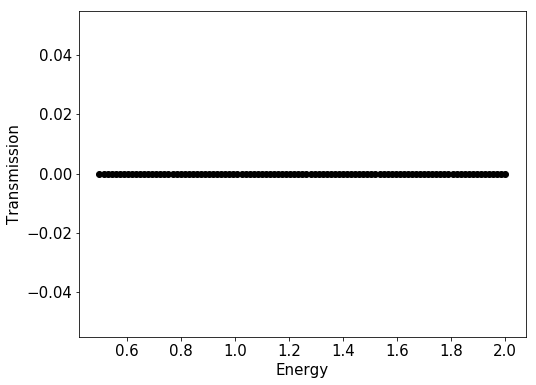

In [153]:
wire2 = make_wire()
del wire2[lieb.shape(lambda pos: pos[0] < 3 and pos[0] > 2 and abs(pos[1]) <5 , (2,0))] # Hole at the center
kwant.plot(wire2,site_color=family_color,site_lw=0.05,hop_lw=hopping_lw);
wire2 = wire2.finalized()
plot_transmission(wire2,np.linspace(0.5,2,101))

Now we have cut the nanoribbon and the transmission is 0. However, adding a 3rd nearest neighbor probability should make the Transmission non-zero

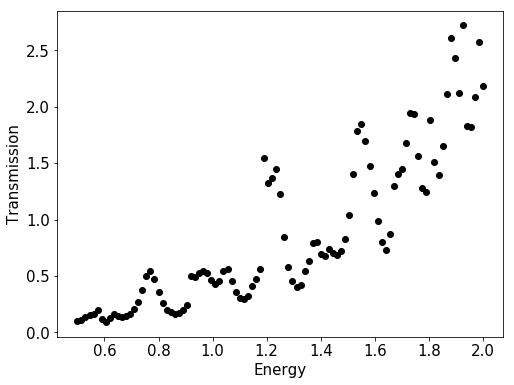

In [154]:
wire2 = make_wire()
wire2[lieb.neighbors(3)] = 0.25
del wire2[lieb.shape(lambda pos: pos[0] < 3 and pos[0] > 2 and abs(pos[1]) <5 , (2,0))] # Hole at the center
wire2 = wire2.finalized()
plot_transmission(wire2,np.linspace(0.5,2,101))


Now let's make the potential in the scattering region non-zero and not flat

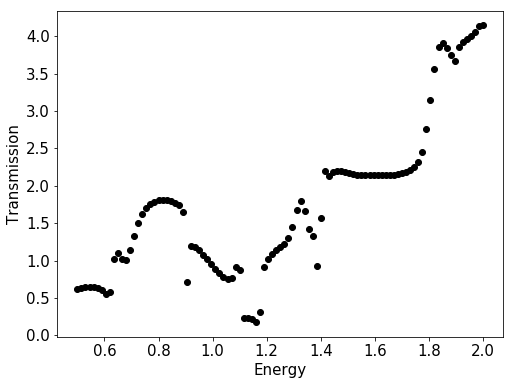

In [155]:
def make_wire_with_potential(W=10, L=30, t=1):
    """ Returns a nanowire with a circular potential pillar at the center 
    and with leads attached at the ends along x-direction"""
    def onsite(site):
        r = 2 
        x,y = site.pos 
        if x**2 + y**2 < r**2:
            return 2*t 
        else: 
            return 0
    # Construct the scattering region.
    wr = kwant.Builder()
    wr[lieb.shape(lambda pos: abs(pos[0]) < L/2 and abs(pos[1])<W/2,(0,0))] = onsite
    wr[lieb.neighbors()] = t

    # Build and attach lead from both sides.
    lead = make_lead_x(W, t)
    wr.attach_lead(lead)
    wr.attach_lead(lead.reversed())

    return wr

wire_wp = make_wire_with_potential() 
wire_wp = wire_wp.finalized()
plot_transmission(wire_wp,np.linspace(0.5,2,101))

## Lieb Quantum dot

In [156]:
def make_lead_y(W,t):
    """ Returns a lead with width W and nearest neighbor hopping parameter t"""
    lead = kwant.Builder(kwant.TranslationalSymmetry(lieb.prim_vecs[1]))
    lead[lieb.shape(lambda pos: abs(pos[0]) < W/2,(0,0))] = 0 
    lead[lieb.neighbors()] = t
    return lead


def make_dot(center, radius, t=1):
    """Returns a quantum dot"""
    def is_inside(pos):
        x, y = pos - center
        return x**2 + y**2 < rr

    rr = radius**2
    syst = kwant.Builder()
    syst[lieb.shape(is_inside, center)] = 0
    syst[lieb.neighbors()] = 1

    return syst

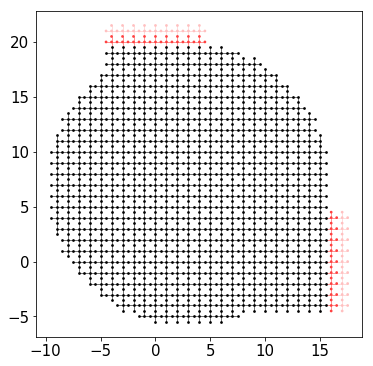

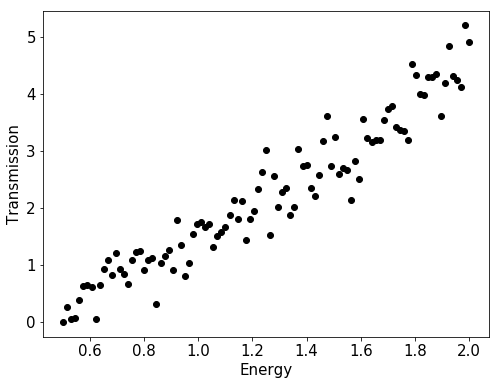

In [157]:
lieb_dot = make_dot((3,7),13)
lieb_dot.attach_lead(make_lead_x(10,1))
lieb_dot.attach_lead(make_lead_y(10,1))
kwant.plot(lieb_dot)
lieb_dot = lieb_dot.finalized()
plot_transmission(lieb_dot,np.linspace(0.5,2,101))


In [158]:
# Eigen values of Hamiltonian
ham = lieb_dot.hamiltonian_submatrix()
eval, evec = la.eigh(ham)

from ipywidgets import interact

def plot_wf(i=0):
    print("Plotting wave function with index", i)
    print("energy:", eval[i],"x t") 
    kwant.plotter.map(lieb_dot, abs(evec[:, i])**2)
    
interact(plot_wf, i=(0, 100));

interactive(children=(IntSlider(value=0, description='i'), Output()), _dom_classes=('widget-interact',))